# Explainable Deep Learning

Class: AIPI 590

Javidan Karimli

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/18T9YjiQ5Nx50ClkCmlaV-JY-osflu89K?usp=drive_link)

In this notebook, we explore drone classification. Over the past decade, drone detection has become an increasingly important topic for safety and security reasons. Our goal is to determine whether an image contains a drone and to apply and discuss Grad-CAM and its variations to understand which parts of the image the model focuses on during detection.

We use a pretrained ResNet-50 model and fine-tune it by adding a final layer specifically for drone detection.

In [ ]:
!pip -q install grad-cam


In [ ]:
# === Basic libraries ===
import os, glob, random, warnings
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

warnings.filterwarnings('ignore')

# === Kaggle dataset helper ===
import kagglehub

# === PyTorch / Torchvision ===
import torch
import torchvision as tv
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

# GradCAM
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Download latest version
path = kagglehub.dataset_download("dasmehdixtr/drone-dataset-uav")

print("Path to dataset files:", path)

OUT_ROOT = "data/drone_cls"

Using Colab cache for faster access to the 'drone-dataset-uav' dataset.
Path to dataset files: /kaggle/input/drone-dataset-uav


In [ ]:
def find_and_copy_images(root, out_dir, n=5, copy_to_new_path = True):
    """
    Find up to n images from dataset subfolders and copy them into out_dir.
    This prevents data leakage (testing on training data).
    """

    candidates = [
        "dataset_xml_format", "dataset_xml_format/dataset_xml_format",
        "JPEGImages", "images", ".", "drone_dataset_yolo"
    ]
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.JPG","*.PNG")
    imgs = []

    for sub in candidates:
        p = Path(root)/sub
        if not p.exists():
            continue
        for ext in exts:
            imgs += glob.glob(str(p / "**" / ext), recursive=True)
        if len(imgs) >= n:
            break

    if not imgs:
        raise FileNotFoundError("No images found. Update DATASET_ROOT or provide your own image paths.")

    chosen = imgs[:n]
    copied_paths = []

    if copy_to_new_path:

      # Create output dir
      out_dir = Path(out_dir)
      out_dir.mkdir(parents=True, exist_ok=True)

      for img in chosen:
          dst = out_dir / Path(img).name
          shutil.copy(img, dst)
          copied_paths.append(str(dst))

      print(f"Copied {len(copied_paths)} images to {out_dir}")

    return copied_paths if copied_paths else chosen

In [ ]:
image_paths = find_and_copy_images(path, n=5, out_dir = 'test_images')

Copied 5 images to test_images
Using images: ['test_images/pic_243.jpg', 'test_images/pic_772.jpg', 'test_images/pic_098.jpg', 'test_images/pic_075.jpg', 'test_images/pic_1076.jpg']


Since we need to split the training images to train the model, I want to avoid testing it on the either same images or splitted images used during training. Therefore, I exclude five images from the training set and store them separately to evaluate the model’s final performance.

## Training Preparation

In [ ]:
random.seed(42)

LABEL_DIR = os.path.join(path, 'drone_dataset_yolo/dataset_txt')  # adjust to your path
IMG_DIR   =  os.path.join(path, 'drone_dataset_yolo/dataset_txt') # if images are in same folder

OUT_ROOT = Path("/content/drone_cls")
for sub in ["train/drone","train/background","val/drone","val/background","test/drone","test/background"]:
    (OUT_ROOT/sub).mkdir(parents=True, exist_ok=True)


IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff",".JPG",".PNG"}
stem_to_img = {}
for p in Path(path).rglob("*"):
    if p.suffix in IMG_EXTS:
        stem_to_img[p.stem] = str(p)

In [ ]:
def find_image_by_stem(stem: str):
    return stem_to_img.get(stem, None)

# Using yolo to split the image and classify
def read_yolo(txt_path, W, H):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    with open(txt_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]
    for ln in lines:
        parts = ln.split()
        if len(parts) < 5:
            continue
        _, xc, yc, w, h = map(float, parts[:5])
        x1 = int((xc - w/2) * W); y1 = int((yc - h/2) * H)
        x2 = int((xc + w/2) * W); y2 = int((yc + h/2) * H)
        # clamp to image bounds
        x1 = max(0, min(W-1, x1)); y1 = max(0, min(H-1, y1))
        x2 = max(0, min(W-1, x2)); y2 = max(0, min(H-1, y2))
        if x2 > x1 and y2 > y1:
            boxes.append([x1,y1,x2,y2])
    return boxes

def iou(a,b):
    ax1,ay1,ax2,ay2=a; bx1,by1,bx2,by2=b
    ix1,iy1 = max(ax1,bx1), max(ay1,by1)
    ix2,iy2 = min(ax2,bx2), min(ay2,by2)
    iw,ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    if inter == 0: return 0.0
    area_a = (ax2-ax1)*(ay2-ay1)
    area_b = (bx2-bx1)*(by2-by1)
    return inter / (area_a + area_b - inter + 1e-6)

def random_bg(W, H, pos_boxes, tries=60, iou_thr=0.03):
    smin, smax = int(0.12*min(W,H)), int(0.45*min(W,H))
    for _ in range(tries):
        bw = random.randint(max(32, smin), max(33, smax))
        bh = random.randint(max(32, smin), max(33, smax))
        if bw >= W or bh >= H:
            continue
        x1 = random.randint(0, W - bw)
        y1 = random.randint(0, H - bh)
        cand = [x1, y1, x1 + bw, y1 + bh]
        if all(iou(cand, pb) <= iou_thr for pb in pos_boxes):
            return cand
    return None

def save_pos_crop(img, box, pad_ratio=0.12):
    H, W = img.shape[:2]
    x1,y1,x2,y2 = box
    dx, dy = int(pad_ratio*(x2-x1)), int(pad_ratio*(y2-y1))
    x1, y1 = max(0, x1 - dx), max(0, y1 - dy)
    x2, y2 = min(W-1, x2 + dx), min(H-1, y2 + dy)
    if x2 <= x1 or y2 <= y1:
        return None
    return img[y1:y2, x1:x2]

In [ ]:
txts = [f for f in os.listdir(LABEL_DIR) if f.endswith(".txt")]
txts.sort()
random.shuffle(txts)
n = len(txts); ntr = int(0.7*n); nva = int(0.15*n)
splits = {"train": txts[:ntr], "val": txts[ntr:ntr+nva], "test": txts[ntr+nva:]}

# Loop through to create a split
for split, files in splits.items():
    pos_dir = OUT_ROOT / split / "drone"
    neg_dir = OUT_ROOT / split / "background"

    pos_count = 0
    neg_count = 0
    for f in files:
        stem = f[:-4]
        imgp = find_image_by_stem(stem)
        if not imgp:
            continue

        im = cv2.imread(imgp)
        if im is None:
            continue
        H, W = im.shape[:2]
        boxes = read_yolo(os.path.join(LABEL_DIR, f), W, H)

        # POSITIVES
        if boxes:
            for bi, b in enumerate(boxes):
                crop = save_pos_crop(im, b, pad_ratio=0.12)
                if crop is not None and crop.size:
                    cv2.imwrite(str(pos_dir / f"{stem}_b{bi}.jpg"), crop)
                    pos_count += 1

        # BACKGROUNDS
        need_bg = 2 if split == "test" else 2
        made_bg = 0
        for _ in range(need_bg):
            nb = random_bg(W, H, boxes, tries=80, iou_thr=0.03)
            if nb:
                x1,y1,x2,y2 = nb
                crop = im[y1:y2, x1:x2]
                if crop.size:
                    cv2.imwrite(str(neg_dir / f"{stem}_n{random.randint(0,99999)}.jpg"), crop)
                    made_bg += 1
                    neg_count += 1

    print(f"{split}: wrote {pos_count} drone, {neg_count} background")

print("Binary dataset built at", OUT_ROOT)

train: wrote 1042 drone, 1894 background
val: wrote 225 drone, 408 background
test: wrote 219 drone, 408 background
Binary dataset built at /content/drone_cls


The code above performs all the necessary groundwork to reorganize the original folder structure into a new format that includes separate train, test, and validation folders for two classes: drone and background. The background images are randomly cropped from the original images, while the drone images are obtained by detecting drones using the YOLO object detection model and cropping them accordingly.


## Training the ResNet - 50

In [ ]:
DEVICE="cuda" if torch.cuda.is_available() else "cpu"
IMG=224; BATCH=32; EPOCHS=5


In [ ]:
train_tf=transforms.Compose([
    transforms.Resize((IMG,IMG)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
eval_tf=transforms.Compose([
    transforms.Resize((IMG,IMG)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

train_ds=tv.datasets.ImageFolder(OUT_ROOT/"train",transform=train_tf)
val_ds=tv.datasets.ImageFolder(OUT_ROOT/"val",transform=eval_tf)
test_ds=tv.datasets.ImageFolder(OUT_ROOT/"test",transform=eval_tf)
train_dl=DataLoader(train_ds,batch_size=BATCH,shuffle=True)
val_dl=DataLoader(val_ds,batch_size=BATCH)
test_dl=DataLoader(test_ds,batch_size=BATCH)

weights=tv.models.ResNet50_Weights.IMAGENET1K_V2
model=tv.models.resnet50(weights=weights)

for p in model.parameters():
   p.requires_grad=False

model.fc=nn.Linear(model.fc.in_features,2)
model=model.to(DEVICE)

opt=optim.AdamW(model.fc.parameters(),lr=1e-3,weight_decay=1e-4)
crit=nn.CrossEntropyLoss()


In this section, several transformations are applied to prepare the dataset for drone classification. All images are resized to a fixed dimension, randomly flipped horizontally to add variation during training, converted into tensors, and normalized using standard ImageNet mean and standard deviation values. The images are then organized into train, validation, and test folders, and each folder is loaded using the ImageFolder class to create datasets. Data loaders are set up to efficiently handle batching and shuffling during training. A pretrained ResNet-50 model with ImageNet weights is then loaded, and all layers are frozen to preserve previously learned features. The final fully connected layer is replaced with a new one that outputs two classes which are drone and background. The model is moved to the selected device, and the AdamW optimizer and cross-entropy loss function are used to train the new classification layer.

In [ ]:
def run_epoch(dl,train=True):
    model.train(train)
    tot,correct,n=0,0,0
    for x,y in dl:
        x,y=x.to(DEVICE),y.to(DEVICE)
        if train: opt.zero_grad()
        out=model(x); loss=crit(out,y)
        if train: loss.backward(); opt.step()
        tot+=loss.item(); pred=out.argmax(1)
        correct+=(pred==y).sum().item(); n+=y.size(0)
    return tot/len(dl), correct/n

In [ ]:
for e in range(1,EPOCHS+1):
    tl,ta=run_epoch(train_dl,True)
    vl,va=run_epoch(val_dl,False)
    print(f"Epoch {e}: train {ta:.3f} | val {va:.3f}")

torch.save({"state":model.state_dict(),"classes":train_ds.classes},"drone_linear.pt")
print("Classes:", train_ds.classes)

Epoch 1: train 0.941 | val 0.972
Epoch 2: train 0.977 | val 0.976
Epoch 3: train 0.979 | val 0.976
Epoch 4: train 0.986 | val 0.983
Epoch 5: train 0.985 | val 0.980
Classes: ['background', 'drone']


The model was trained for five epochs, and the accuracy scores showed consistently promising results. This strong performance can be explained by the distinct nature of the classification problem, which makes it relatively easy for the model to differentiate between drone and background images. Overall, by the final epoch, the model achieved an impressive accuracy of 0.98, indicating that it learned to recognize drones with high precision.

## Load and test trained model

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT   = "drone_linear.pt"
TEST_DIR = "/content/drone_cls/test"

# 1) Rebuild model
weights = tv.models.ResNet50_Weights.IMAGENET1K_V2
model = tv.models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: background, drone

ckpt = torch.load(CKPT, map_location="cpu")
model.load_state_dict(ckpt["state"])
classes = ckpt["classes"]         # ['background', 'drone']
model.eval().to(DEVICE)

eval_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])



Using original images: 5
[1] pic_243.jpg → pred: drone (p=1.000) | probs: {'background': np.float32(0.0), 'drone': np.float32(1.0)}


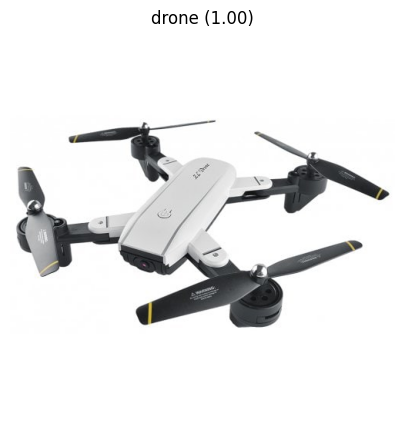

[2] pic_772.jpg → pred: drone (p=1.000) | probs: {'background': np.float32(0.0), 'drone': np.float32(1.0)}


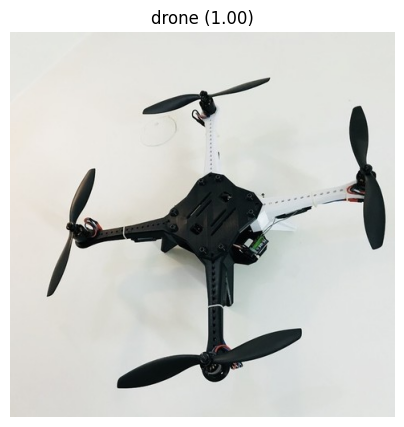

[3] pic_098.jpg → pred: drone (p=1.000) | probs: {'background': np.float32(0.0), 'drone': np.float32(1.0)}


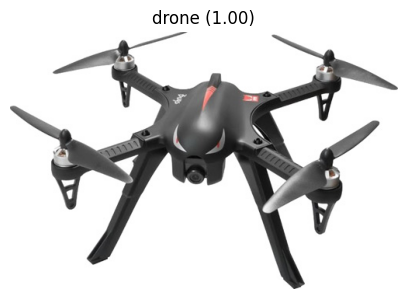

[4] pic_075.jpg → pred: drone (p=1.000) | probs: {'background': np.float32(0.0), 'drone': np.float32(1.0)}


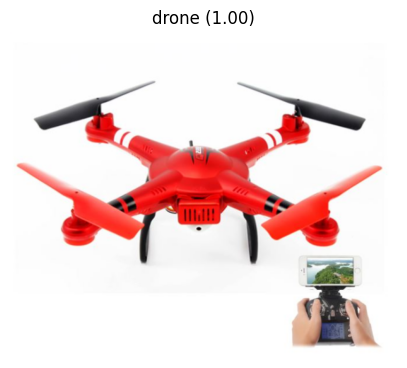

[5] pic_1076.jpg → pred: background (p=1.000) | probs: {'background': np.float32(1.0), 'drone': np.float32(0.0)}


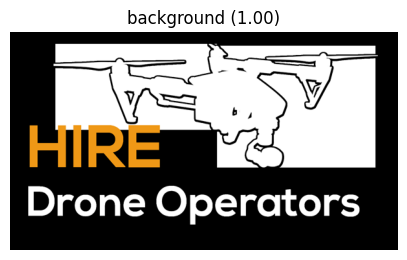

In [ ]:
print("Using original images:", len(image_paths))

# Custom prediction function to classify images
@torch.no_grad()
def predict_one(img_path):
    img = Image.open(img_path).convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(DEVICE)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    top_idx = int(probs.argmax())
    return classes[top_idx], float(probs[top_idx]), img, probs


# Looping through the images to classify
for i, p in enumerate(image_paths, 1):
    label, conf, img, probs = predict_one(p)
    print(f"[{i}] {Path(p).name} → pred: {label} (p={conf:.3f}) | probs: {dict(zip(classes, np.round(probs,3)))}")
    plt.figure(figsize=(5,5))
    plt.imshow(img); plt.axis("off")
    plt.title(f"{label} ({conf:.2f})")
    plt.show()

In this section, the pretrained model is loaded to bypass the training process and directly run inference using the already trained weights. The model’s predictions are then demonstrated on five different drone images. Overall, the model performs well in most cases, accurately identifying drones in the images. However, in the last example, it classifies the image as background instead of a drone, which seems debatable. This prediction can still be considered reasonable, as the image only contains a faint sketch of a drone in the background rather than a clearly visible drone.

## Grad-Cam implementation

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT   = "drone_linear.pt"          # your saved head
OUTDIR = Path("/content/outputs_cam")
OUTDIR.mkdir(parents=True, exist_ok=True)

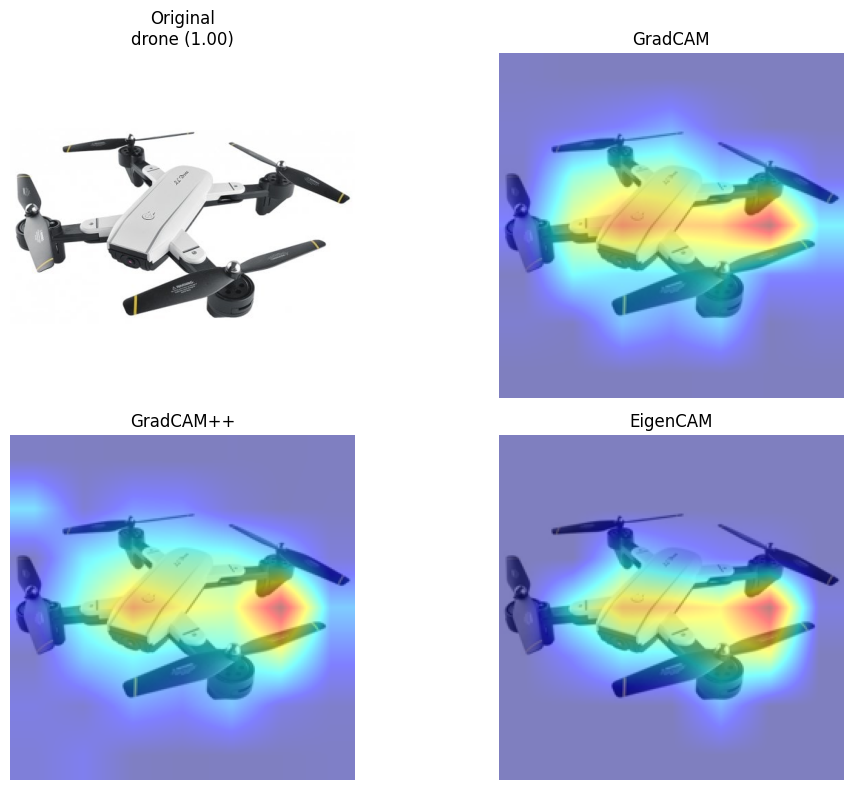

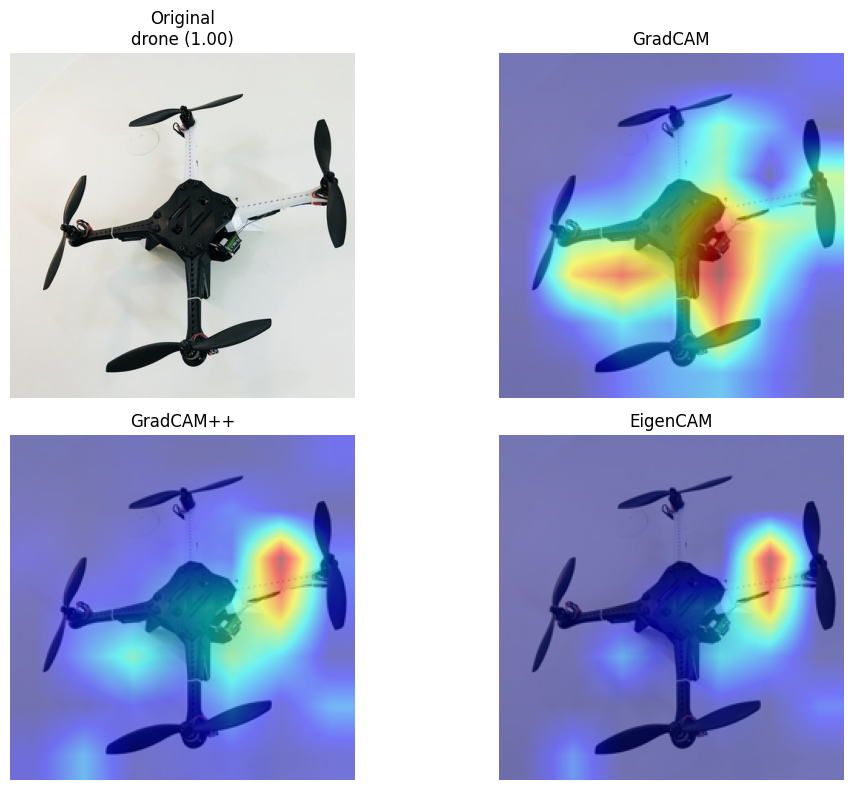

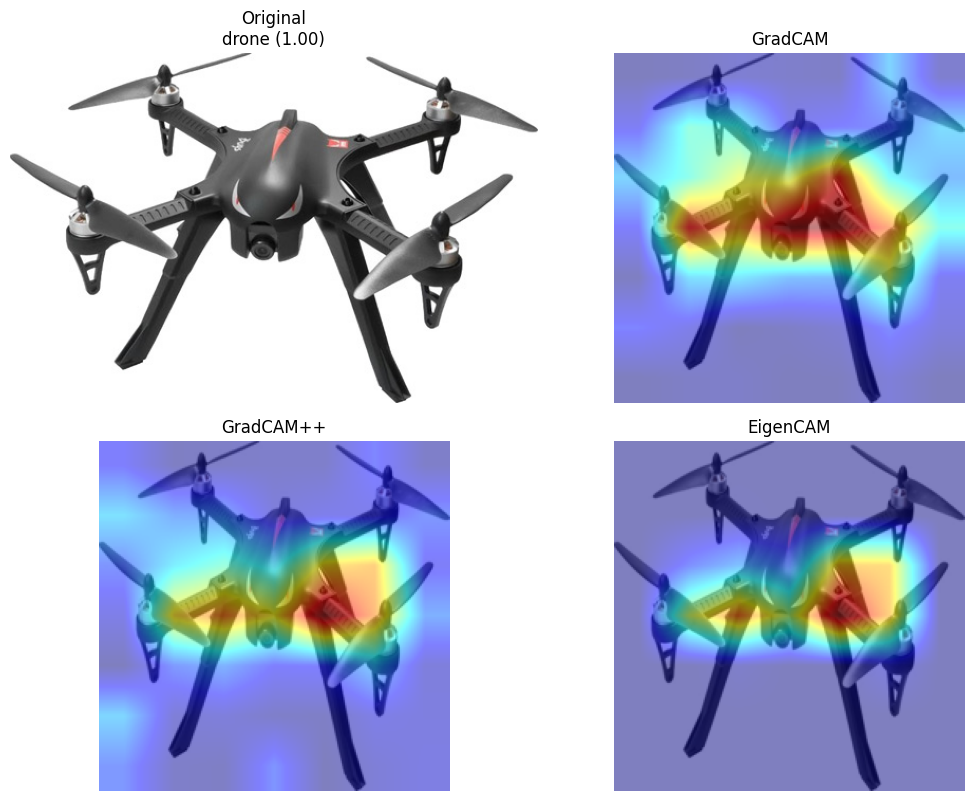

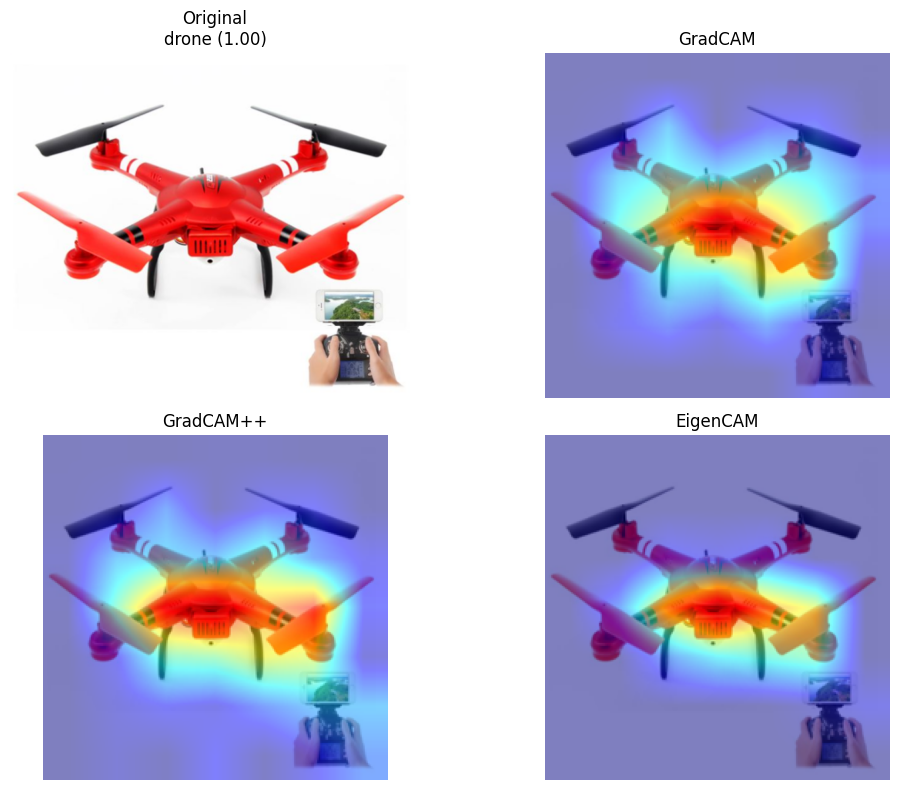

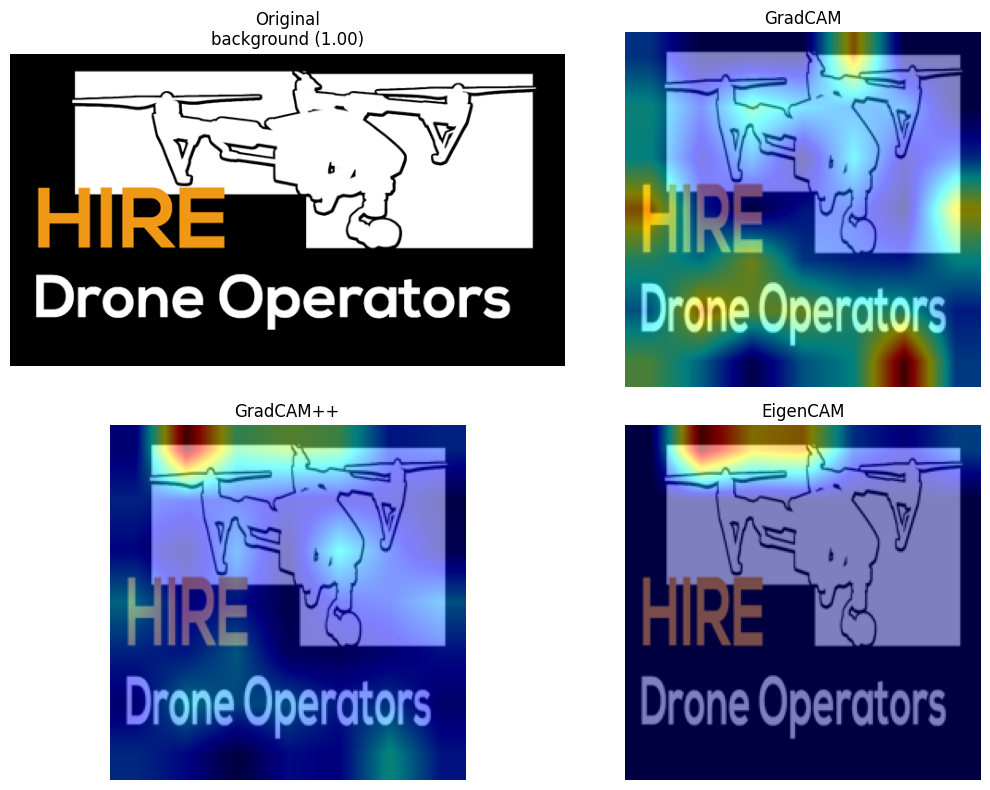

In [ ]:
target_layers = [model.layer4[-1]]

cams = {
    "GradCAM":   GradCAM(model=model, target_layers=target_layers),
    "GradCAM++": GradCAMPlusPlus(model=model, target_layers=target_layers),
    "EigenCAM":  EigenCAM(model=model, target_layers=target_layers),
}

def pil_to_float01(pil_img):
    return (np.array(pil_img.convert("RGB")).astype(np.float32)) / 255.0

for i, p in enumerate(image_paths, 1):
    img = Image.open(p).convert("RGB")
    x = eval_tf(img).unsqueeze(0).to(DEVICE)

    # forward (keep grads enabled for CAM)
    logits = model(x)
    probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
    top_idx = int(probs.argmax())
    top_label, top_conf = classes[top_idx], float(probs[top_idx])


    cam_h, cam_w = int(x.shape[-2]), int(x.shape[-1])
    np_img = pil_to_float01(img)

    # resize image to CAM size so shapes match (H, W, 3)
    np_img_resized = np.array(img.resize((cam_w, cam_h), Image.BICUBIC)).astype(np.float32) / 255.0

    targets = [ClassifierOutputTarget(top_idx)]
    overlays = []
    for name, cam in cams.items():
        grayscale = cam(input_tensor=x, targets=targets)[0]
        overlay = show_cam_on_image(np_img_resized, grayscale, True)
        overlays.append((name, overlay))

    plt.figure(figsize=(11,8))
    ax = plt.subplot(2,2,1); ax.imshow(img); ax.axis("off")
    ax.set_title(f"Original\n{top_label} ({top_conf:.2f})")
    for j,(name,ov) in enumerate(overlays, start=2):
        ax = plt.subplot(2,2,j); ax.imshow(ov); ax.axis("off"); ax.set_title(name)
    plt.tight_layout()
    plt.show()

## Reflection

So GradCam and it's 2 different variation GradCAM ++ and EigenCAM applied to the 5 images which have shown previously. Briefly, GradCAM works by using the gradients of the final convolutional layer to locate areas most responsible for the model’s prediction, GradCAM++ is a refined version that accounts for multiple important regions within the same class activation map and EigenCAM, on the other hand, uses principal component analysis (PCA) of feature maps instead of gradients, producing a smoother and more generalized activation map.

Across these visualizations, the three methods GradCAM, GradCAM++, and EigenCAM—highlight slightly different aspects of how the model interprets drone and non-drone images. In the GradCAM results, the activation maps tend to be broader and cover large regions around the drone body and propellers, showing that the model’s attention is generally distributed across the key structural components. GradCAM++, however, produces sharper and more localized attention regions, particularly focusing on the propeller tips, the central body, and areas of high contrast. This indicates a finer sensitivity to specific discriminative parts that distinguish drones from the background. EigenCAM generates smoother and more global heatmaps by analyzing the dominant feature which sometimes makes it capture the entire silhouette rather than fine details.

Overall, propellers and legs are the most predominant parts the model uses to decide whether an image contains a drone or not, with only small variations across examples. It focuses mainly on the distinctive areas of the drone where the background contrast changes significantly, allowing it to separate the object from its surroundings.

One of the surprising results is that, in the last image, the model completely focuses on the black background and the text rather than the silhouette of the drone sketch. This indicates that the actual structure of the drone is not always treated as an important factor in the model’s classification. As mentioned earlier, this case is debatable because the image doesn’t show a real drone, but it still provides valuable insight into the model’s behavior.

Explainability is especially important in this context because drone detection systems can be integrated with anti-drone technologies such as jamming or defensive targeting systems. Expanding this work to include radar or infrared data could enhance detection reliability and provide a clearer understanding of aerial objects. However, incorrect detections could harm flying entities like birds or even commercial aircraft. Therefore, understanding and explaining why the model classifies an object as a drone is crucial before deploying such systems in real-world scenarios.




Throughout the notebook, the GPT-5 model was used to refine and polish the written text, ensuring a more professional and coherent presentation. In addition to writing support, the model was also utilized to assist with the implementation of the model development process and the GradCAM methods.